# The Capacitated Vehicle Routing Problem

A short example of using **Iterated Local Search** to model and solve the CRVP

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take routing software years to find the optimal solution... 

In [16]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from metapy.tsp.euclidean import gen_matrix, euclidean_distance
from metapy.local_search.two_opt import OrdinaryDecentTwoOpt
from metapy.local_search.random_restarts import (IteratedLocalSearch, 
                                                 EpsilonGreedyHomeBase)
from metapy.tsp.objective import CVRPUnitDemandObjective

from joblib import Parallel, delayed

## Helper functions

In [17]:
def multiple_runs(n_patients, random_states, ils_iter, instance_seed=101, 
                  n_jobs=-1):
    '''
    Perform multiple parallel runs of ILS
    '''
    x_coords, y_coords = generate_instance(n_patients, 
                                           random_state=instance_seed)
    
    coords = [[x, y] for x, y in zip(x_coords, y_coords)]
    matrix = gen_matrix(np.array(coords))
    
    
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(n_patients, matrix, rs, 
                   ils_iter) for rs in random_states)
    
    return res

def single_run(n_patients, distance_matrix, random_state, ils_iter=20):
    '''
    Perform a single run of ILS
    '''
    init_solution = np.arange(n_patients+1)
    ils_solver = create_solver(distance_matrix, 
                               4, 
                               init_solution, 
                               random_state=random_state)
    ils_solver.run(n=ils_iter)
    return ils_solver.get_best_solutions()[0]

In [18]:
def plot_solution(routes, x_coords, y_coords):
    
    xc = x_coords
    yc = y_coords
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        plt.plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        plt.plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')
    
    i = 1
    for x, y in zip(x_coords[1:], y_coords[1:]):
        #plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
        i += 1
        

In [19]:
def generate_instance(n_patients, random_state=None):

    #random number generator for synthetic data.
    rand_gen = RandomState(seed=random_state)

    #n_patients = 1 so we include the depot
    x_coords = rand_gen.random(size=n_patients+1) * 200
    y_coords = rand_gen.random(size=n_patients+1) * 100

    return x_coords, y_coords

In [20]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

In [21]:
def convert_tour_to_routes(tour, capacity):
    '''
    Easy as demand comes in single units and
    capacity is an integer
    '''
    n_cities = len(tour)
    capacity = int(capacity)
    splits = [i for i in range(capacity, n_cities, capacity)]
    routes = np.split(tour, splits)
    return routes

In [22]:
def create_solver(matrix, capacity, init_solution, random_state=None):
    '''
    create an istance of a ILS solver
    '''
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)
    local_search = OrdinaryDecentTwoOpt(cvrp_obj, init_solution)
    ils = IteratedLocalSearch(cvrp_obj, 
                              local_search, 
                              accept=EpsilonGreedyHomeBase(), 
                              maximisation=False,
                              random_state=random_state)
    return ils

In [27]:
def load_and_plot_solution(filename):
    active_arcs = pd.read_csv(filename).to_numpy()

    xc = x_coords
    yc = y_coords

    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        plt.plot(xc[0], yc[0], c='r', marker='^')
        plt.scatter(xc[1:], yc[1:], c='b')
        
    plt.show()

In [39]:
def comparison_plot(routes, x_coords, y_coords, comparison_file_name,
                    label_1 = 'ILS', label_2='Gurobi'):
    xc = x_coords
    yc = y_coords
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            ax[0].plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        ax[0].plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        ax[0].plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    ax[0].plot(xc[0], yc[0], c='r', marker='^')
    ax[0].scatter(xc[1:], yc[1:], c='b')
    ax[0].set_title(label_1)
    
    active_arcs = pd.read_csv(comparison_file_name).to_numpy()

    for i, j in active_arcs:
        ax[1].plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        ax[1].plot(xc[0], yc[0], c='r', marker='^')
        ax[1].scatter(xc[1:], yc[1:], c='b')
    ax[1].set_title(label_2)

    

## Parameters

## Patient Geographic Location

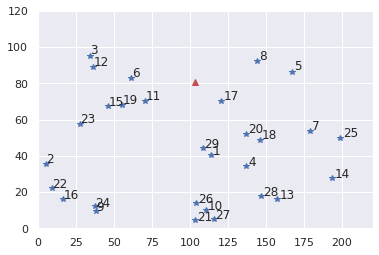

In [23]:
N_PATIENTS = 30
SEED = 101

#visualise
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=SEED)
plot_patient_coordinates(x_coords, y_coords)

## Approaches to 'solving' the CVRP

* Formulation as a Mixed Integer Programme (MIP) and use of a optimisation solver
* **Solution via meta-heursitic**.  E.g. Iterated Local Search.

## Some sample instances and results from Gurobi

| No. Patients | Run time (mins) | Best found | Optimality gap (%) |
|:------------:|:---------------:|:----------:|:------------------:|
|      10      |      < 0.01     |     529    |          0         |
|      30      |       150       |    1426    |         39         |
|      60      |        20       |    2548    |         64         |
|      100     |        20       |    2877    |        89          |

## Solution using Iterated Local Search

In [24]:
%%time 
N_PATIENTS = 30
INSTANCE_SEED = 101
ILS_ITERS = 20 

#create patient data, distance between patients and initial solution.
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=INSTANCE_SEED)
coords = [[x, y] for x, y in zip(x_coords, y_coords)]
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))

#use ILS to generate a 'good' solution.
ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=28)
ils_solver.run(n=ILS_ITERS)

print(f'ILS solution: {ils_solver.get_best_solutions()[0]:.2f}')

ILS solution: 1452.55
CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.48 s


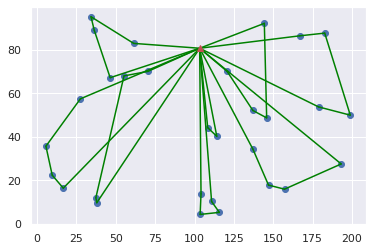

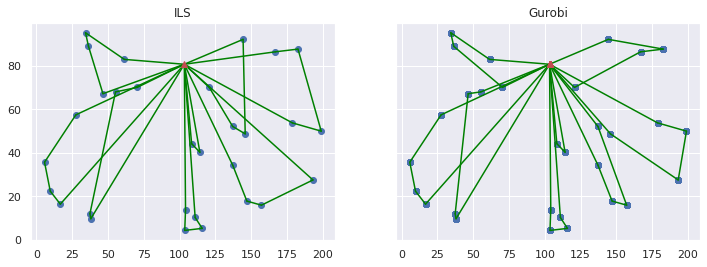

In [40]:
solution = ils_solver.get_best_solutions()[1][0]
routes = convert_tour_to_routes(solution[1:], 4)
plot_solution(routes, x_coords, y_coords)
comparison_plot(routes, x_coords, y_coords, 'best_solution_30_patients.csv')

In [44]:
import time

start = time.time()
N_PATIENTS = 60

#three runs of ILS to examine avg performance...
results = multiple_runs(N_PATIENTS, [19, 41, 28], ils_iter=20, n_jobs=-1)
print(results, end='=> ')
print(f'mean: {np.mean(results):.2f}')
print(f'time taken: {time.time() - start:.2f}s')

[2551.4419104020685, 2539.7537397328565, 2509.1595628179944]=> mean: 2533.45
time taken: 25.79s


### Some example ILS results

ILS was used to analyse 3 runs.

| No. Patients | Run time (mins; 3 runs) | Best found |  Avg | Gurobi Best | 
|:------------:|:-----------------------:|:----------:|:----:|:-------------:|
|      10      |          < 0.01         |     529    |  539 | 529         | 
|      30      |           0.05          |    1452    | 1470 | 1426        | 
|      60      |           0.25          |    2509    | 2540 | 2548        | 
|      100     |           2.56          |    3727    | 3746 | 2877        | 

In [42]:
#np.savetxt('ils_best_100_solution_20reps.csv', solution, delimiter=',')

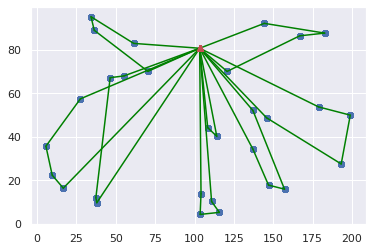

In [28]:
load_and_plot_solution('best_solution_30_patients.csv')